In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import mxnet.ndarray as nd
import numpy as np
ctx = mx.cpu()

# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
#get the dataset
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

In [6]:

def evaluate_accuracy(data_iterator, net, loss_fun):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        output = net(data)
        loss = loss_fun(output, label)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_avg

def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)
    plt.show()
    

Completed epoch 1. Train Loss: 2.183161020278931, Test Loss 2.2076181769371033, Train_acc 0.239, Test_acc 0.209
Completed epoch 21. Train Loss: 0.9006108045578005, Test Loss 1.102285835891962, Train_acc 0.827, Test_acc 0.741
Completed epoch 41. Train Loss: 0.6550136283040047, Test Loss 0.8717543110251428, Train_acc 0.864, Test_acc 0.77
Completed epoch 61. Train Loss: 0.5540741626173259, Test Loss 0.7677281647920606, Train_acc 0.878, Test_acc 0.781
Completed epoch 81. Train Loss: 0.48715284653007984, Test Loss 0.7064204029738903, Train_acc 0.886, Test_acc 0.797
Completed epoch 101. Train Loss: 0.4415114838629961, Test Loss 0.664454624056816, Train_acc 0.899, Test_acc 0.809
Completed epoch 121. Train Loss: 0.4068870861083269, Test Loss 0.6344267278909684, Train_acc 0.903, Test_acc 0.817
Completed epoch 141. Train Loss: 0.38471067510545237, Test Loss 0.6108758840709926, Train_acc 0.913, Test_acc 0.818
Completed epoch 161. Train Loss: 0.35799141786992555, Test Loss 0.592692282050848, Train

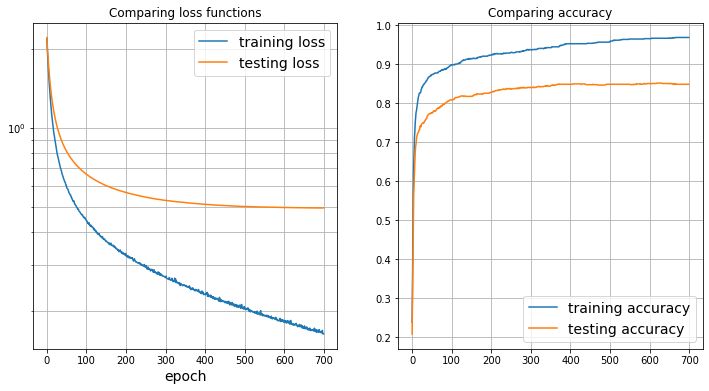

In [7]:
#create a model

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))
    
#init params
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

#choose softmax cross entropy loss
loss = gluon.loss.SoftmaxCrossEntropyLoss()

#create SGD optimizer with weight decay wd = 0 to see the overfitting effect
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0})


#Execute training loop

epochs = 700
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)


Completed epoch 1. Train Loss: 2.189238429069519, Test Loss 2.2069937139749527, Train_acc 0.219, Test_acc 0.207
Completed epoch 21. Train Loss: 0.9021228142082692, Test Loss 1.109550133347511, Train_acc 0.822, Test_acc 0.727
Completed epoch 41. Train Loss: 0.6604907475411892, Test Loss 0.8761103339493277, Train_acc 0.859, Test_acc 0.761
Completed epoch 61. Train Loss: 0.5493531096726656, Test Loss 0.7716017737984656, Train_acc 0.878, Test_acc 0.777
Completed epoch 81. Train Loss: 0.4816517289727927, Test Loss 0.7110976614058019, Train_acc 0.894, Test_acc 0.796
Completed epoch 101. Train Loss: 0.4437725637108087, Test Loss 0.6699631102383137, Train_acc 0.904, Test_acc 0.801
Completed epoch 121. Train Loss: 0.41011618450284004, Test Loss 0.6399229746311904, Train_acc 0.91, Test_acc 0.812
Completed epoch 141. Train Loss: 0.3847761135548353, Test Loss 0.6166945341974499, Train_acc 0.912, Test_acc 0.821
Completed epoch 161. Train Loss: 0.36486154794692993, Test Loss 0.5989326033741234, Trai

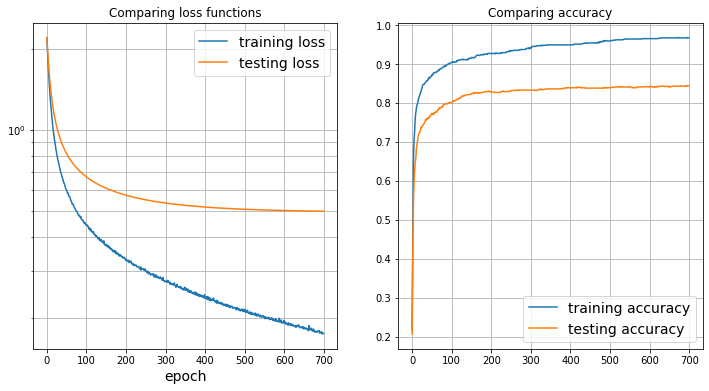

In [8]:
#Setting weight decay some 0.001, a non zero value
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.001})

moving_loss = 0.
niter=0
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net,loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)